In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import timeit

import pandas as pd
import geopy

# Scrape online data

In [3]:
URL = 'https://www.beeradvocate.com/beer/profile/2958/87869/'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')


In [50]:
res = soup.find(id='info_box')

In [16]:
beerstats = soup.find_all(class_='beerstats')

In [32]:
bold = res.find_all('b')

In [33]:
bold

[<b>Beer Geek Stats:</b>,
 <b>Style:</b>,
 <b>Belgian Saison</b>,
 <b>ABV:</b>,
 <b>5%</b>,
 <b>Score:</b>,
 <b>94</b>]

In [57]:
soup.find(title="Learn more about this style.").find('b').text

'Belgian Saison'

In [65]:
soup.find_all(title="Percentage of alcohol by volume.")[-1].find('b').text[:-1]

'5'

In [55]:
soup.find(class_="ba-score Tooltip").text

'94'

In [54]:
soup.find(class_="ba-ravg Tooltip").text

'4.26'

In [60]:
soup.find(title="View more beers and info from this brewery.").text

'BFM (Brasserie des Franches-Montagnes)'

In [64]:
soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text

'Switzerland'

In [75]:
soup.find(class_="titleBar")

<div class="titleBar">
<h1>XV (√225 Saison)<br/><span style="color:#999999; font-size:0.75em;">BFM (Brasserie des Franches-Montagnes)</span></h1>
</div>

In [81]:
soup.find('title').text.split('|')[0].strip()

'XV (√225 Saison)'

In [94]:
def parse_beer_page(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    name = soup.find('title').text.split('|')[0].strip()
    style = soup.find(title="Learn more about this style.").find('b').text
    alc_perc = float(soup.find_all(title="Percentage of alcohol by volume.")[-1].find('b').text[:-1])
    
    score_temp = soup.find(class_="ba-score Tooltip")
    if score_temp is not None:
        score = float(score_temp.text)
    else: score = np.NaN
    rating = float(soup.find(class_="ba-ravg Tooltip").text)
    brewery = soup.find(title="View more beers and info from this brewery.").text
    country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
    
    return dict(name=name, style=style, alc_perc=alc_perc, 
                score=score, rating=rating, brewery=brewery, country=country)
    

In [165]:
def get_beer_country(url, session=requests):
    try:
        page = session.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
    except:
        country = ''
    return country

In [99]:
parse_beer_page('https://www.beeradvocate.com/beer/profile/2385/87878/')

{'name': 'Dark Ale',
 'style': 'American Brown Ale',
 'alc_perc': 4.0,
 'score': nan,
 'rating': 3.44,
 'brewery': 'Black Duck Brewery',
 'country': 'Australia'}

In [106]:
get_beer_country('https://www.beeradvocate.com/beer/profile/2/3/')

'United States'

In [109]:
countries = []
url = 'https://www.beeradvocate.com/beer/profile/2/{}/'
for i in range(100):
    try:
        countries.append(get_beer_country(url.format(i)))
    except:
        print(i)
    

1
2
22
25
53
57
60
64
70
77
91
98


In [167]:
s = requests.Session()
timeit.timeit(lambda: get_beer_country(url.format(15002),s), number=5)

3.777793766999821

In [146]:
timeit.timeit(lambda: requests.head(url.format(19)), number=1)

0.8501878259994555

In [147]:
requests.head(url.format(19))

<Response [301]>

In [149]:
1.5* 100000 / 3600

41.666666666666664

## Check parallel requests

In [160]:
import eventlet

urls = [url.format(i) for i in range(50)]
pool = eventlet.GreenPool(50)

countries = []
def pool_work():
    for country in pool.imap(get_beer_country, urls):
        countries.append(country)
        print('one is done')

timeit.timeit(pool_work, number=1)

one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done


60.20601609700043

In [154]:
urls

['https://www.beeradvocate.com/beer/profile/2/3/',
 'https://www.beeradvocate.com/beer/profile/2/4/',
 'https://www.beeradvocate.com/beer/profile/2/5/',
 'https://www.beeradvocate.com/beer/profile/2/6/',
 'https://www.beeradvocate.com/beer/profile/2/7/',
 'https://www.beeradvocate.com/beer/profile/2/8/',
 'https://www.beeradvocate.com/beer/profile/2/9/',
 'https://www.beeradvocate.com/beer/profile/2/10/',
 'https://www.beeradvocate.com/beer/profile/2/11/',
 'https://www.beeradvocate.com/beer/profile/2/12/',
 'https://www.beeradvocate.com/beer/profile/2/13/',
 'https://www.beeradvocate.com/beer/profile/2/14/',
 'https://www.beeradvocate.com/beer/profile/2/15/',
 'https://www.beeradvocate.com/beer/profile/2/16/',
 'https://www.beeradvocate.com/beer/profile/2/17/',
 'https://www.beeradvocate.com/beer/profile/2/18/',
 'https://www.beeradvocate.com/beer/profile/2/19/',
 'https://www.beeradvocate.com/beer/profile/2/20/',
 'https://www.beeradvocate.com/beer/profile/2/21/',
 'https://www.beera

In [169]:
from concurrent.futures import ThreadPoolExecutor
from requests_futures.sessions import FuturesSession

session = FuturesSession(max_workers=5)
cs = []
timeit.timeit(lambda: cs.append(get_beer_country(url.format(15002),session)), number=5)

0.007156055999985256

In [172]:
cs

['', '', '', '', '']

In [175]:
from concurrent.futures import as_completed
from requests_futures.sessions import FuturesSession

def get_beer_countries_parall(urls):
    countries = []
    session = FuturesSession(max_workers=5)
    
    futures = [session.get(url) for url in urls]
    for future in as_completed(futures):
        try:
            resp = future.result()
            soup = BeautifulSoup(resp.content, 'html.parser')
            country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
            countries.append(country)
        except:
            pass
    
    return countries

In [187]:
def get_swiss_beers_parall(urls):
    swissbeers = []
    session = FuturesSession(max_workers=5)
    
    futures = [session.get(url) for url in urls]
    for future in as_completed(futures):
        try:
            resp = future.result()
            soup = BeautifulSoup(resp.content, 'html.parser')
            country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
            if country == 'Switzerland':
                swissbeers.append(resp.url)
        except:
            pass
    
    return swissbeers

In [176]:
urls = [url.format(i) for i in range(50)]

timeit.timeit(lambda: get_beer_countries_parall(urls), number=1)

6.967507653000212

In [184]:
session = FuturesSession(max_workers=5)

future = session.get(url.format(19))

In [185]:
resp = future.result()

In [186]:
resp.url

'https://www.beeradvocate.com/beer/profile/9/19/'

In [188]:
swiss_beers_urls = get_swiss_beers_parall([url.format(i) for i in range(1000)])

In [189]:
swiss_beers_urls

[]

In [191]:
460000 * (7/50)

64400.00000000001

In [194]:
30*60/(7/50)

12857.142857142855

In [195]:
swiss_beers_urls_to12k = get_swiss_beers_parall([url.format(i) for i in range(12000)])

KeyboardInterrupt: 

## Login to BeerAdvocate

In [4]:
s = requests.Session()
url_login = 'https://www.beeradvocate.com/community/login/login'
with open('ba_credentials','r') as f:
    login, password = f.read().splitlines()

In [5]:
 
payload = {'login': login, 'password': password}
page = s.post(url_login, data=payload)

In [277]:
with open('test.html','bw') as f:
    f.write(page.content)

In [10]:
url_ch = 'https://www.beeradvocate.com/place/list/?c_id=CH&s_id=0&brewery=Y'
url_ch2 = 'https://www.beeradvocate.com/place/list/?start=20&&c_id=CH&brewery=Y&sort=name'
ch_page1 = s.get(url_ch)

In [278]:
url_ch_gen = 'https://www.beeradvocate.com/place/list/?start={}&&c_id=CH&brewery=Y&sort=name'

In [281]:
ch_end = s.get(url_ch_gen.format(140))
soup_ch_end = BeautifulSoup(ch_end.content)
list_ch_end = soup_ch_end.find_all(href=lambda x: x and x.startswith('/beer/profile/'))
list_ch_end

[]

In [274]:
with open('test2.html','bw') as f:
    f.write(ch_end.content)

In [258]:
len(list_ch_end)

0

## List all CH breweries

In [298]:
base_url = 'https://www.beeradvocate.com'
def brewery_extract(row):
    cols = row.find_all('td')
    first_el = cols[0].find('a')
    link = base_url +first_el['href']
    brewery_name = first_el.text
    def treat_dash(text):
        if text=='-':
            return 'nan'
        else:
            return text
    ratings, nbeers = [treat_dash(x.text) for x in cols[-2:]]
    ratings = float(ratings)
    nbeers = int(nbeers)
    dic = dict(
        name = brewery_name, link = link,
        ratings = ratings, n_beers = nbeers
        )
    return dic
    

In [299]:
def treat_address(list_ad):
    ad = ''
    for el in list_ad:
        if el.name == 'br':
            ad += '\n'
        elif el.name == 'a':
            ad += el.get_text()
        else:
            ad += str(el).strip()
    ad = ad.split('\n\n')
    ad = list(map(lambda x: x.strip(), ad))
    if len(ad) == 2:
        address, tel = ad
    else:
        address = ad[0]
        tel = ''
    return dict(address=address, telephone=tel)

In [302]:
def breweries_from_page(page):
    table_rows = iter(page.find('table').find_all('tr'))
    breweries = []
    for row in table_rows:
        #columns = row.find_all('td')
        #table.append([el.text.rstrip() for el in columns])
        if row.find(href=lambda x: x and x.startswith('/beer/profile/')):
            brew_dic = brewery_extract(row)
            address_row = next(table_rows).find('td')
            list_ad = list(address_row.children)
            brew_dic.update(treat_address(list_ad))
            breweries.append(brew_dic)
    return breweries

In [303]:
s = requests.Session()
url_login = 'https://www.beeradvocate.com/community/login/login'

with open('ba_credentials','r') as f:
    login, password = f.read().splitlines() 
payload = {'login': login, 'password': password}
page = s.post(url_login, data=payload)

url_ch_gen = 'https://www.beeradvocate.com/place/list/?start={}&&c_id=CH&brewery=Y&sort=name'
start_n = 0
search = True
breweries_ch = []
while search:
    brew_page = BeautifulSoup(s.get(url_ch_gen.format(start_n)).content)
    more_breweries = brew_page.find_all(href=lambda x: x and x.startswith('/beer/profile/'))
    if len(more_breweries) >0 :
        breweries_ch += breweries_from_page(brew_page)
    else:
        search=False
    
    start_n += 20
    print(start_n)
    


20
40
60
80
100
120
140
160


In [304]:
breweries_ch_df = pd.DataFrame(breweries_ch)

In [305]:
breweries_ch_df

,name,link,ratings,n_beers,address,telephone
0,4655 Brewing Company,https://www.beeradvocate.com/beer/profile/41488/,NaN,4,"Stüsslingen, 4655\nSwitzerland",
1,523,https://www.beeradvocate.com/beer/profile/44206/,3.79,2,"Sonnenweg 30\nKöniz, 3098\nSwitzerland",+41 77 450 7655
2,7Peaks Brasserie,https://www.beeradvocate.com/beer/profile/39040/,2.72,9,"Route de la Patinoire 15a\nMorgins, 1875\nSwit...",+41 78 797 1875
3,À tue-tête,https://www.beeradvocate.com/beer/profile/52843/,4.14,9,"Chemin de la Biole 10\nAigle, 1860\nSwitzerland",+41 79 235 56 49
4,Ahoi Bier,https://www.beeradvocate.com/beer/profile/42305/,3.67,4,"Schlieren, 8952,Switzerland",
...,...,...,...,...,...,...
135,Volta Bräu,https://www.beeradvocate.com/beer/profile/39036/,NaN,2,"Voltastrasse 30\nBasel, 4056\nSwitzerland",+41 61 690 91 29
136,Wadi-Brau-Huss AG,https://www.beeradvocate.com/beer/profile/9378/,NaN,0,"Florhofstrasse 13\nWadenswill, 8820\nSwitzerland",01 783 9392
137,Wartauer Seegal Bräu,https://www.beeradvocate.com/beer/profile/39074/,NaN,8,"Hauptstrasse 33/35\nTrübbach, 9477\nSwitzerland",+41 78 878 19 52
138,Weedbeer,https://www.beeradvocate.com/beer/profile/32639/,3.00,1,"Chemin de l'Etraz 14\nOrbe, 1350\nSwitzerland",+41 21 312 68 21


## Data exploration

In [6]:
breweries_ch_df.sort_values('n_beers', ascending=False)

,name,link,ratings,n_beers,address,telephone,latitude,longitude
40,Brasserie Trois Dames,https://www.beeradvocate.com/beer/profile/17998/,3.80,39,"Rue de France 1\nSainte-Croix, 1450\nSwitzerland",+41 24 454 4375,46.822481,6.500209
85,Feldschlösschen Beverages Group,https://www.beeradvocate.com/beer/profile/555/,2.96,28,"Theophil-Roniger-Strasse\nRheinfelden, 4310\nS...",+41 (0)61 833 48 48,47.546253,7.791998
57,Brauerei Locher AG,https://www.beeradvocate.com/beer/profile/5687/,3.58,24,"Brauereiplatz\nAppenzell, 9050\nSwitzerland",0041 71 787 13 18,47.330883,9.412324
12,BFM (Brasserie des Franches-Montagnes),https://www.beeradvocate.com/beer/profile/2958/,4.16,23,"Chemin des Buissons 8\nSaignelégier, 2350\nSwi...",+41 32 951 26 26,47.254249,7.002505
18,Birrificio Ticinese,https://www.beeradvocate.com/beer/profile/24571/,3.53,15,"Via Vite 5\nStabio, 6855\nSwitzerland",+41 (0)91 695 41 90,45.842084,8.923446
...,...,...,...,...,...,...,...,...
99,Krügel BIER,https://www.beeradvocate.com/beer/profile/39067/,NaN,0,"Obergütschstrasse 26\nLuzern, 6003\nSwitzerland",+41 79 451 10 52,47.045563,8.289678
100,L'Apaisée,https://www.beeradvocate.com/beer/profile/56127/,NaN,0,"19 Route des Jeunes\nCarouge, 1227\nSwitzerland",+41786144220,46.184449,6.130242
101,La Brasse-Mortier,https://www.beeradvocate.com/beer/profile/39019/,NaN,0,"Place du Bourg 9\nRomainmôtier, 1323\nSwitzerland",+41 79 124 54 80,46.694438,6.460887
103,La Brasserie du Griffon,https://www.beeradvocate.com/beer/profile/39060/,NaN,0,"Avenue de l'Industrie 47B\nMonthey, 1870\nSwit...",+41 24 471 42 14,46.253542,6.957299


## Find geographical coordinates of breweries

In [41]:
from  geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent='beer-scraper')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.5)

def address_to_coordinates(ad):
    ad_com = ad.replace('\n',', ')
    loc = geocode(ad_com)
    if loc is None:
        partial_ad = ', '.join(ad.split('\n')[1:])
        loc = geocode(partial_ad)
        if loc is None:
            return float('nan'), float('nan')
    return loc.latitude, loc.longitude

In [309]:
breweries_ch_df['address'][17]

'Via Sotto Bisio 3A\nBalerna, 6828\nSwitzerland'

In [330]:
from  geopy.geocoders import Nominatim
geolocator = Nominatim()
loc = geolocator.geocode(address)
#print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [362]:
address = breweries_ch_df['address'][50]

In [329]:
address

'Obergrundstrasse 110, Luzern, 6002, Switzerland'

In [322]:
loc

Location(Birrificio Sottobisio, 3A, Via Sotto Bisio, Bisio, Balerna, Circolo di Balerna, Distretto di Mendrisio, Ticino, 6828, Switzerland, (45.8443345, 9.0078042, 0.0))

In [331]:
loc.latitude, loc.longitude

(47.04039495, 8.297661748848313)

In [35]:
breweries_ch_df.loc[5]

name                         Aktienbrauerei Flims Surselva AG
link         https://www.beeradvocate.com/beer/profile/20175/
ratings                                                  4.03
n_beers                                                     1
address           Waldhaus\nFlims Waldhaus, 7018\nSwitzerland
telephone                                     41 81 928 14 00
latitude                                              46.8273
longitude                                             9.28622
Name: 5, dtype: object

In [34]:
address_to_coordinates(breweries_ch_df['address'][5])

(46.827296700000005, 9.286218266858235)

In [349]:
breweries_ch_df['address'][2].replace('\n', ', ')

'Route de la Patinoire 15a, Morgins, 1875, Switzerland'

In [38]:
breweries_ch_df["latitude"], breweries_ch_df["longitude"] = zip(
    *breweries_ch_df["address"].map(address_to_coordinates))

In [358]:
loc = geolocator.geocode('7Peaks')

In [360]:
loc is None

True

In [367]:
', '.join(address.split('\n')[1:])

'Luzern, 6002, Switzerland'

In [30]:
# Try google maps
import geopy.geocoders as geocoders
#geolocator = Nominatim(user_agent='beer-scraper')
geolocator = geocoders.OpenMapQuest(user_agent='beer-scraper')

loc = geolocator.geocode('Route de Bas-Vièze 83, 1875 Morgins, Switzerland', timeout=5)
#loc = geolocator.geocode('Morgins, Switzerland', timeout=5)
loc

ConfigurationError: OpenMapQuest requires an API key

In [31]:
from geopy.geocoders import GoogleV3
geolocator = GoogleV3()
address, (latitude, longitude) = geolocator.geocode("175 5th Avenue NYC")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Since July 2018 Google requires each request to have an API key. Pass a valid `api_key` to GoogleV3 geocoder to hide this warning. See https://developers.google.com/maps/documentation/geocoding/usage-and-billing
  


GeocoderQueryError: Your request was denied.

In [62]:
# Fixing missing coordinates by hand
breweries_ch_df[breweries_ch_df['latitude'].isna()]

,name,link,ratings,n_beers,address,telephone,latitude,longitude
95,Il Fermento,https://www.beeradvocate.com/beer/profile/58104/,NaN,0,"Via Marconi 2\nPalazzi Gargantini\nLugano, 690...",+41 (0) 91 923 45 45,NaN,NaN
126,Steinfels,https://www.beeradvocate.com/beer/profile/21242/,3.17,4,"Heinrichstrasse 267\nEcher Wyss Platz\nZürich,...",41 (0)44 271 10 30,NaN,NaN
136,Wadi-Brau-Huss AG,https://www.beeradvocate.com/beer/profile/9378/,NaN,0,"Florhofstrasse 13\nWadenswill, 8820\nSwitzerland",01 783 9392,NaN,NaN


In [73]:
breweries_ch_df.loc[136]['address']

'Florhofstrasse 13\nWadenswill, 8820\nSwitzerland'

In [78]:
loc = address_to_coordinates('Florhofstrasse 9, 8820 Wädenswil')
loc

(47.2308218, 8.6695479)

In [80]:
ind = 136
#breweries_ch_df.loc[ind,'latitude'], breweries_ch_df.loc[ind, 'longitude'] = loc

In [61]:
breweries_ch_df.loc[ind]

name                                            Engadiner Bier
link          https://www.beeradvocate.com/beer/profile/44231/
ratings                                                   3.59
n_beers                                                      3
address      Via Da la Staziun 51\nPostfach 110\nPontresina...
telephone                                     +41 81 842 68 31
latitude                                               46.4913
longitude                                              9.89583
Name: 82, dtype: object

## Save Breweries dataframe

In [83]:
breweries_ch_df.to_pickle('breweries_ch_pickled')

In [2]:
# read pickle

breweries_ch_df = pd.read_pickle('breweries_ch_pickled')

In [3]:
breweries_ch_df

,name,link,ratings,n_beers,address,telephone,latitude,longitude
0,4655 Brewing Company,https://www.beeradvocate.com/beer/profile/41488/,NaN,4,"Stüsslingen, 4655\nSwitzerland",,47.392886,7.971289
1,523,https://www.beeradvocate.com/beer/profile/44206/,3.79,2,"Sonnenweg 30\nKöniz, 3098\nSwitzerland",+41 77 450 7655,46.925468,7.416251
2,7Peaks Brasserie,https://www.beeradvocate.com/beer/profile/39040/,2.72,9,"Route de la Patinoire 15a\nMorgins, 1875\nSwit...",+41 78 797 1875,46.237659,6.858102
3,À tue-tête,https://www.beeradvocate.com/beer/profile/52843/,4.14,9,"Chemin de la Biole 10\nAigle, 1860\nSwitzerland",+41 79 235 56 49,46.309735,6.944491
4,Ahoi Bier,https://www.beeradvocate.com/beer/profile/42305/,3.67,4,"Schlieren, 8952,Switzerland",,47.396515,8.444486
...,...,...,...,...,...,...,...,...
135,Volta Bräu,https://www.beeradvocate.com/beer/profile/39036/,NaN,2,"Voltastrasse 30\nBasel, 4056\nSwitzerland",+41 61 690 91 29,47.570967,7.579546
136,Wadi-Brau-Huss AG,https://www.beeradvocate.com/beer/profile/9378/,NaN,0,"Florhofstrasse 13\nWadenswill, 8820\nSwitzerland",01 783 9392,47.230822,8.669548
137,Wartauer Seegal Bräu,https://www.beeradvocate.com/beer/profile/39074/,NaN,8,"Hauptstrasse 33/35\nTrübbach, 9477\nSwitzerland",+41 78 878 19 52,47.073017,9.480788
138,Weedbeer,https://www.beeradvocate.com/beer/profile/32639/,3.00,1,"Chemin de l'Etraz 14\nOrbe, 1350\nSwitzerland",+41 21 312 68 21,46.720308,6.539114


## Mapbox bubble map

In [31]:
breweries_ch_df[breweries_ch_df['name'].apply(lambda s: 'Hoppy' in s)]

,name,link,ratings,n_beers,address,telephone,latitude,longitude
93,Hoppy People,https://www.beeradvocate.com/beer/profile/48536/,3.76,10,"Route Des Sablons 11\nSierre, 3960\nSwitzerland",+41 (0)27 455-00 00,47.050545,8.305468


In [32]:
breweries_ch_df[breweries_ch_df['name'].apply(lambda s: '7Peaks' in s)]

,name,link,ratings,n_beers,address,telephone,latitude,longitude
2,7Peaks Brasserie,https://www.beeradvocate.com/beer/profile/39040/,2.72,9,"Route de la Patinoire 15a\nMorgins, 1875\nSwit...",+41 78 797 1875,47.050545,8.305468


In [86]:
import plotly.express as px
import plotly.offline as py
px.set_mapbox_access_token(open(".mapbox_token").read())

fig = px.scatter_mapbox(breweries_ch_df, 
                        lat="latitude", lon="longitude",     
                        color="ratings", size="n_beers",
                        text='name',
                  color_continuous_scale=px.colors.sequential.Viridis, 
                        size_max=15, zoom=6)
#fig.show()
py.plot(fig, filename='swiss-breweries-map.html')

'swiss-breweries-map.html'

In [57]:
import plotly.express as px
import plotly.offline as py
px.set_mapbox_access_token(open(".mapbox_token").read())

fig = px.scatter_mapbox(breweries_ch_RB_df, 
                        lat="latitude", lon="longitude",     
                        #color="established_year", size="beer_count",
                        color="beer_count", 
                        text='name',
                  color_continuous_scale=px.colors.sequential.Viridis, 
                        size_max=15, zoom=6)
#fig.show()
py.plot(fig, filename='swiss-breweries-map-RB.html')

'swiss-breweries-map-RB.html'

## Selecting items on map

In [7]:
import plotly.graph_objs as go
from ipywidgets import Output, VBox
import plotly.express as px


map = px.scatter_mapbox(breweries_ch_df, 
                        lat="latitude", lon="longitude",     
                        color="ratings", size="n_beers",
                        text='name',
                  color_continuous_scale=px.colors.sequential.Viridis, 
                        size_max=15, zoom=6)
fig = go.FigureWidget(map)

out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    print(points.point_inds)

#pie.on_click(handle_click)
fig.data[0].on_click(handle_click)

VBox([fig, out])

    'data': [{'hoverlabel': {'namelength': 0},
              'hovertemplate': ('…

## Get list of beers from each breweries

### Attemps with Untappd

In [15]:
# test untapped
#cookies = {'uid': '232323', 'pass': '32323232323232323232323',
#           '__cfduid': '2323232323adasdasdasdas78d6asdasjdgawi8d67as'}
cookies = {'Name': 'untappd_user_v3_e', 
           'Value': 'cf983db65cd6570b3aa37c006adf1491321592df48ef861c4c75ad3c12a93d0c20890aba646fcc0d12a8102d34b655df916b54bee8927d0ed18daf7d1fac9880vdaSZ3BwBT8TUKJ14m29MMk8ztYNxJWrCsNgWTFrqXOjt0a6GddRjI2IPA3rXn0EbH0WlNXTT0WvdjeQjdFeZA%3D%3D',
           }
url_ut = 'https://untappd.com/w/brasserie-des-franches-montagnes-bfm/4719/beer'

#page_ut = requests.get(url_ut, cookies=cookies)
page_ut = requests.get(url_ut)
#soup_ut = BeautifulSoup(page_ut, 'lxml')

with open('test_untappd.html','bw') as f:
    f.write(page_ut.content)

In [20]:
#url_b = 'https://untappd.com/b/brasserie-des-franches-montagnes-bfm-225-saison/270389'
url_b = 'https://untappd.com/home'
page_ut = requests.get(url_b)

with open('test_untappd.html','bw') as f:
    f.write(page_ut.content)


In [21]:
page_ut.content

b'Too Many Requests'

### Attemps with RateBeer

In [32]:
url_RB_search = 'https://www.ratebeer.com/search?q={}&tab=brewer'

#brewery_name = breweries_ch_df.loc[51,'name'].replace(' ', '+')
brewery_name = 'Fri-Mousse'
page_RB_search = requests.get(url_RB_search.format(brewery_name))
with open('test_RB.html','bw') as f:
    f.write(page_RB_search.content)

In [27]:
brewery_name

'Brauerei+Erusbacher+&+Paul+AG'

In [29]:
breweries_ch_df.loc[37,'name'].replace(' ', '+')


'Brasserie+Fri-Mousse'

In [33]:
url_RB_search.format(brewery_name)

'https://www.ratebeer.com/search?q=Fri-Mousse&tab=brewer'

In [125]:
from selenium import webdriver
#my_url = 'https://www.ratebeer.com/search?q=trois+dames&tab=brewer'
my_url = 'https://www.ratebeer.com/search?q=Brasserie+Fri-Mousse&tab=brewer'
base_url = 'https://www.ratebeer.com' 

driver = webdriver.PhantomJS()
driver.set_window_position(0, 0)
driver.set_window_size(1024, 768)
driver.get(my_url)
page_brewery_search = driver.page_source
with open('test_RB_search.html','w') as f:
    f.write(page_brewery_search)
    
soup_rb_search = BeautifulSoup(page_brewery_search)
link_brewery = base_url + soup_rb_search.find(href=lambda x: x and x.startswith('/brewers/'))['href']
link_brewery

/usr/local/lib/python3.7/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


TypeError: 'NoneType' object is not subscriptable

'/brewers/trois-dames/5898/'

In [40]:
html

'<html><head></head><body></body></html>'

In [76]:
from selenium import webdriver
my_url = 'https://www.ratebeer.com/brewers/fri-mousse/2195/'
driver = webdriver.PhantomJS()
driver.set_window_position(0, 0)
driver.set_window_size(1024, 768)
driver.get(my_url)
page_brewery = driver.page_source
with open('test_RB.html','w') as f:
    f.write(page_brewery)


/usr/local/lib/python3.7/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [42]:
soup_rb = BeautifulSoup(driver.page_source)
list_beers_rb = soup_rb.find_all(href=lambda x: x and x.startswith('/beer'))
#list_beers_rb[1].find_all(class_='fd-r')

In [77]:
soup_rb = BeautifulSoup(page_brewery)

In [106]:
print(soup_rb.find_all('tr')[2].find_all('td')[0].prettify())


<td class="MuiTableCell-root MuiTableCell-body py-4 MuiTableCell-sizeSmall">
 <div class="fd-r fa-c">
  <div class="fd-c fj-s ml-4">
   <a href="/beer/fri-mousse-le-charbonnier/24494/">
    <div class="fd-r fa-c">
     <div _color="#424242" _css="" _css2="" _css3="" _css4="" _css5="" _css6="" _css7="" class="MuiTypography-root Text___StyledTypographyTypeless-bukSfn pzIrn text-500 colorized__WrappedComponent-hrwcZr bRPQdN MuiTypography-subtitle1">
      Fri-Mousse Le Charbonnier
     </div>
    </div>
   </a>
   <div class="fd-r fa-c">
    <div _color="#757575" _css="" _css2="" _css3="" _css4="" _css5="" _css6="" _css7="" class="MuiTypography-root Text___StyledTypographyTypeless-bukSfn pzIrn colorized__WrappedComponent-hrwcZr gRvDpm fd-r fa-c MuiTypography-body2">
     Smoked - Rauchbier
    </div>
   </div>
  </div>
 </div>
</td>



In [115]:
[a.text for a in soup_rb.find_all('tr')[1].find_all('td')[0].find_all(class_=lambda x: x and x.startswith('MuiTypography'))]

['Brasserie Artisanale de Fribourg Framboise',
 'RETIRED  •  ',
 'Flavored - Fruit']

In [116]:
list_brews = []
for row in soup_rb.find_all('tr'):
    r = []
    for el in row.find_all('td'):
    #for el in row.find_all(class_=lambda x: x and x.startswith('MuiTypography')):
        r.append(el.text)
    list_brews.append(r)
list_brews

[[],
 ['Brasserie Artisanale de Fribourg FramboiseRETIRED  •  Flavored - Fruit',
  '-',
  '3.22',
  '62',
  '84',
  '9',
  '4.5',
  'Jan 30, 2002'],
 ['Fri-Mousse Le CharbonnierSmoked - Rauchbier',
  '-',
  '3.29',
  '60',
  '48',
  '31',
  '5.0',
  'Jun 14, 2003'],
 ['Fri-Mousse Old CatStout',
  '-',
  '3.30',
  '58',
  '47',
  '29',
  '5.5',
  'Jan 26, 2002'],
 ['Fri-Mousse Fleur de SureauFlavored - Fruit',
  '-',
  '3.12',
  '49',
  '85',
  '15',
  '5.0',
  'Jun 14, 2003'],
 ['Fri-Mousse la DzodzetHelles / Dortmunder Export',
  '-',
  '3.04',
  '41',
  '89',
  '9',
  '4.8',
  'Jun 12, 2006'],
 ['Fri-Mousse BarbeblancheWeissbier - Hefeweizen',
  '-',
  '2.99',
  '31',
  '45',
  '24',
  '5.0',
  'Jan 23, 2002'],
 ['Brasserie Artisanale de Fribourg Pale Ale 1047RETIRED  •  Pale Ale - English',
  '-',
  '2.76',
  '29',
  '28',
  '12',
  '4.8',
  'Jun 14, 2003'],
 ['Fri-Mousse BarberousseRed Ale / Intl Amber Ale',
  '-',
  '2.80',
  '26',
  '29',
  '16',
  '5.5',
  'Jan 23, 2002'],
 ['Br

In [87]:
soup_rb.find_all(class_="MuiTableRow-root BeerTableRowListView___StyledTableRow-bnmiUX eitoNp")[1].text

'Fri-Mousse Le CharbonnierSmoked - Rauchbier-3.296048315.0Jun 14, 2003'

In [44]:
list(map(lambda x: x.text, list_beers_rb[1].find_all(class_='fd-r')))

['Brasserie Artisanale de Fribourg Framboise(9)', '62843.22', '3.22', '']

In [72]:
list(list(soup_rb.find(id='root').find(class_='fd-c fa-c').children)[0].children)[1]

<div class="MuiPaper-root MuiPaper-elevation1 fa-c fd-c fj-c mt-5 pt-5 MuiPaper-rounded"><div _css="" _css2="" _css3="" _css4="
                font-size: 18px;
                font-family: 'Fira Sans', 'sans serif' !important;
              " _css5="" _css6="" _css7="" class="MuiTypography-root Text___StyledTypographyTypeless-bukSfn GxGDg colorized__WrappedComponent-hrwcZr hwjOn SectionHeader___StyledText-sBNkO kpPHQk fd-c fa-c MuiTypography-h6">Brewer beers (16)</div><ul class="MobileBrewerBeerList___StyledUl-eOuyrA dZWvjH ml-0 pl-0"><div class="MobileBrewerBeerList___StyledDiv2-iSpTyt dDpcAS"><div class="BeerListItem___StyledDiv-czNOve cEPytL"><a _color="#0d47a1" _css="" _css2="" _css3="" _css4="" _css5="" _css6="" _css7="" class="MuiTypography-root Text___StyledTypographyTypeless-bukSfn pzIrn colorized__WrappedComponent-hrwcZr liJcHu px-4 py-4 fj-s MuiTypography-body2" data-testid="beer-menu-item" href="/beer/brasserie-artisanale-de-fribourg-framboise/11981/" style="text-decoration

In [54]:
#print(list_beers_rb[1].prettify())

In [53]:
list_beers_rb[1].text

'Brasserie Artisanale de Fribourg Framboise(9)🇨🇭 Flavored - Fruit • 4.5%62843.22OUT OF PRODUCTION'

In [55]:
my_url = 'https://www.ratebeer.com/beer/brasserie-artisanale-de-fribourg-framboise/11981/'
driver = webdriver.PhantomJS()
driver.get(my_url)
soup_beer_rb = BeautifulSoup(driver.page_source)

/usr/local/lib/python3.7/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [ ]:
soup_beer_rb

In [126]:
# Grab list of breweries from RateBeer

url_ch_breweries = 'https://www.ratebeer.com/breweries/switzerland/0/191/'
page_rb_breweries = requests.get(url_ch_breweries)

soup_rb_breweries = BeautifulSoup(page_rb_breweries.content)

In [155]:
def treat_row_RB_breweries(row):
    base_url = 'https://www.ratebeer.com' 
    brew, place = row[0].find_all('a')

    place = place.text
    link = base_url +  brew['href']
    name = brew.text.strip()
    #row[0]
    brewer_type = row[1].text
    beer_count = int(row[2].text)
    established = int(row[4].text)
    brewer= dict(
        name=name, link=link,
        location=place, brewer_typ=brewer_type,
        beer_count=beer_count, established_year=established,
    )
    return brewer

In [194]:
for row in soup_rb_breweries.find('table').find_all('tr'):
    l = (len([el for el in row.children]))
    if l != 5:
        print(l)

In [196]:
[el for el in soup_rb_breweries.find('table').find_all('tr')[0].children]

[<th align="left">Name</th>,
 <th align="left">Type</th>,
 <th>Beer Count</th>,
 <th>My Count</th>,
 <th style="text-align:right">Est.</th>]

In [198]:
row = soup_rb_breweries.find('table').find_all('tr')[].find_all('td')
if len(row)>0:
    print(treat_row_RB_breweries(row))

{'name': '1386 Das Sempacher Bier', 'link': 'https://www.ratebeer.com/brewers/1386-das-sempacher-bier/23198/', 'location': 'Sempach', 'brewer_typ': 'Microbrewery', 'beer_count': 2, 'established_year': 2015}


In [199]:
breweries = []
for row in soup_rb_breweries.find('table').find_all('tr'):
    row_els = row.find_all('td')
    if len(row_els)>1:
        breweries.append(treat_row_RB_breweries(row_els))


In [202]:
breweries_ch_RB_df = pd.DataFrame(breweries)


## Saving RateBeer Breweries

In [204]:
breweries_ch_RB_df.to_pickle('breweries_ch_RB_pickled')

In [2]:
# read pickle

breweries_ch_RB_df = pd.read_pickle('breweries_ch_RB_pickled')

In [3]:
breweries_ch_RB_df

,name,link,location,brewer_typ,beer_count,established_year
0,1386 Das Sempacher Bier,https://www.ratebeer.com/brewers/1386-das-semp...,Sempach,Microbrewery,2,2015
1,1936 Bière,https://www.ratebeer.com/brewers/1936-biere/14...,Verbier,Client Brewer,1,2012
2,3 Finger Joe,https://www.ratebeer.com/brewers/3-finger-joe/...,Sachseln,Microbrewery,3,2018
3,4655 Brewing Company,https://www.ratebeer.com/brewers/4655-brewing-...,Stüsslingen,Microbrewery,5,2015
4,7Peaks Brasserie,https://www.ratebeer.com/brewers/7peaks-brasse...,"Morgins, Vaud",Microbrewery,20,2014
...,...,...,...,...,...,...
571,zur Grünen Amsel,https://www.ratebeer.com/brewers/zur-grunen-am...,Riehen,Microbrewery,20,2010
572,Zur Trotte,https://www.ratebeer.com/brewers/zur-trotte/11...,Berg am Irchel,Brewpub,1,2009
573,Zurich Airport Beer (ZAB),https://www.ratebeer.com/brewers/zurich-airpor...,Zürich Flughafen,Client Brewer,2,2011
574,Zweierlei,https://www.ratebeer.com/brewers/zweierlei/29046/,Stans,Microbrewery,3,2016


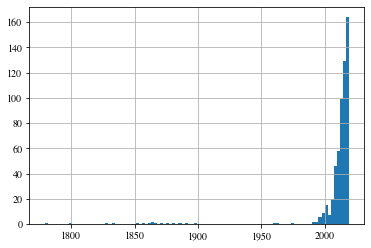

In [209]:
hist = breweries_ch_RB_df['established_year'].hist(bins=100)

### Grabbing more brewery information from RateBeer

In [172]:
from selenium import webdriver
import time

#my_url = breweries_ch_RB_df.loc[12,'link']
search_string = 'Ahoi'
my_url = breweries_ch_RB_df[breweries_ch_RB_df['name'].apply(lambda s: search_string in s)]['link'].values[0]


driver = webdriver.PhantomJS()
driver.set_window_position(0, 0)
driver.set_window_size(1024, 768)
driver.get(my_url)
time.sleep(0.5)

page_brewery = driver.page_source
with open('test_RB.html','w') as f:
    f.write(page_brewery)

In [173]:
soup_brewery = BeautifulSoup(page_brewery)

In [4]:
def treat_brewery_info_RB(soup_brewery, brewer_id):
    brewery = {}
    brewery['brewer_id'] = brewer_id
    brewery['img_link'] = soup_brewery.find(src=lambda x: x and x.startswith("https://res.cloudinary.com/ratebeer/image/"))['src']
    brewery['address'] = soup_brewery.find(href=lambda x: x and x.startswith("http://maps.google.com/")).text
    brewery['telephone'] = soup_brewery.find(href=lambda x: x and x.startswith("tel:")).text
    brewery['website'] = soup_brewery.find(lambda tag:tag.name=="a" and "Website" in tag.text)['href']
    return brewery
    

In [48]:
img_link = soup_brewery.find(src=lambda x: x and x.startswith("https://res.cloudinary.com/ratebeer/image/"))['src']
img_link

'https://res.cloudinary.com/ratebeer/image/upload/w_150,c_limit,d_Default_Brewery_q4okin.png,f_auto/brew_1063.jpg'

In [49]:
address = soup_brewery.find(href=lambda x: x and x.startswith("http://maps.google.com/")).text
address
                                                                                                            


'Chemin des Buissons 8, Saignelégier,  2350, Switzerland'

In [50]:
tel = soup_brewery.find(href=lambda x: x and x.startswith("tel:")).text
tel

' 41 (0) 32 / 951 26 26'

In [51]:
website = soup_brewery.find(lambda tag:tag.name=="a" and "Website" in tag.text)['href']
website

'http://www.brasseriebfm.ch/'

In [108]:
beers_per_page = soup_brewery.find_all(class_='MuiTypography-root MuiTablePagination-caption MuiTypography-body2 MuiTypography-colorInherit')[1].text.split()
tot_beers = int(beers_per_page[2])
beers_at_page = list(map(int,beers_per_page[0].split('-')))
beers_at_page, tot_beers

([1, 100], 161)

In [5]:
def treat_RB_beer_row(row, brewer_id, debug=False):
    list_els = []
    for el in row.find_all(class_=lambda x: x and x.startswith('MuiTypography')):
        list_els.append(el.text)
    if len(list_els) < 9:
        return None
    active = True
    if len(list_els) > 9:
        if 'RETIRED' in list_els[1]:
            active = False
        too_many = len(list_els) - 9
        list_els = [el for i, el in enumerate(list_els) 
                    if  not (i in list(range(1,1+too_many)))]
    if debug:
        print(list_els)
    name = list_els[0]
    style = list_els[1]
    if list_els[3] == '':
        list_els[3]= 'nan'
    ratings_avg = float(list_els[3].replace('-', 'nan'))
    score_overall = int(list_els[4].replace('-', '0'))
    score_style = int(list_els[5].replace('-', '0'))
    number_ratings = int(list_els[6].replace('-', '0'))
    alcohol_perc = float(list_els[7].replace('-', 'nan'))
    added_date = list_els[8]
    beer = dict(
        name=name, style=style, active=active, 
        ratings_avg=ratings_avg, number_ratings=number_ratings,
        score_overall=score_overall, score_style=score_style,
        alcohol_perc=alcohol_perc, date_added=added_date,
        brewer_id=brewer_id,
        )
    return beer
    

In [184]:
list_brews = []
for row in soup_brewery.find_all('tr'):
    r = []
    #for el in row.find_all('td'):
    #for el in row.find_all(class_=lambda x: x and x.startswith('MuiTypography')):
    #    r.append(el.text)
    #list_brews.append(r)
    new_beer = treat_RB_beer_row(row, -1, debug=True)
    if new_beer:
        list_brews.append(new_beer)
#list(map(len,list_brews))
list_brews[2]


['Ahoi Bier Mango Blonde', 'Flavored - Fruit', '-', '3.04', '-', '-', '1', '6.0', 'Sep 16, 2019']
['Ahoi Bier Black Pale Ale', 'Flavored - Other', '-', '3.15', '-', '-', '1', '5.5', 'Dec 28, 2018']
['Ahoi Bier Belgian Triple', 'Tripel', '-', '3.11', '-', '-', '1', '9.0', 'Dec 28, 2018']
['Ahoi Bier Eukalyptic', 'Flavored - Other', '-', '', '-', '-', '1', '5.0', 'Nov 19, 2016']
['Ahoi Bier Passion Fruit', 'Flavored - Fruit', '-', '3.19', '-', '-', '3', '5.6', 'Nov 8, 2016']
['Ahoi Bier / Probier Böögzilla', 'Pale Ale - American / APA', '-', '2.89', '-', '-', '1', '4.9', 'Apr 18, 2016']
['Ahoi Bier Smoky Pistolero', 'Smoked - Rauchbier', '-', '3.29', '-', '-', '4', '7.6', 'Apr 18, 2016']
['Ahoi Bier Whiskey Bier', 'Smoked - Rauchbier', '-', '3.12', '-', '-', '3', '5.1', 'Mar 22, 2016']
['Ahoi Bier Muscovado Lab Version', 'IIPA - Imperial / Double IPA', '-', '3.05', '-', '-', '2', '9.3', 'Jan 16, 2016']
['Ahoi Bier Spruce Lee', 'Red Ale / Intl Amber Ale', '-', '3.09', '-', '-', '2', '6.2'

{'name': 'Ahoi Bier Belgian Triple',
 'style': 'Tripel',
 'active': True,
 'ratings_avg': 3.11,
 'number_ratings': 1,
 'score_overall': 0,
 'score_style': 0,
 'alcohol_perc': 9.0,
 'date_added': 'Dec 28, 2018',
 'brewer_id': -1}

In [111]:
list_brews[-1]

{'name': 'BFM La RDA',
 'style': 'Stout - Imperial',
 'active': True,
 'ratings_avg': 3.11,
 'number_ratings': 1,
 'score_overall': 0,
 'score_style': 0,
 'alcohol_perc': 11.0,
 'date_added': 'Nov 18, 2018'}

In [55]:
soup_brewery.find_all('button',class_="MuiButtonBase-root MuiIconButton-root MuiIconButton-colorInherit")

[<button class="MuiButtonBase-root MuiIconButton-root MuiIconButton-colorInherit" tabindex="0" type="button"><span class="MuiIconButton-label"><svg aria-hidden="true" class="MuiSvgIcon-root" focusable="false" role="presentation" viewbox="0 0 24 24"><path d="M8.59 16.34l4.58-4.59-4.58-4.59L10 5.75l6 6-6 6z"></path></svg></span><span class="MuiTouchRipple-root"></span></button>]

In [63]:
# Click to access page 2

#xpath = '/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]'
xpath = "//button[@class='MuiButtonBase-root MuiIconButton-root MuiIconButton-colorInherit']"

elem = driver.find_element_by_xpath(xpath)
elem.click()
page_brewery2 = driver.page_source
with open('test_RB_2.html','w') as f:
    f.write(page_brewery2)

In [14]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
import warnings
import time

def load_RB_page(url_brewer, debug=False):
    warnings.filterwarnings('ignore')
    driver = webdriver.PhantomJS()
    driver.set_window_position(0, 0)
    driver.set_window_size(1024, 768)
    
    failing = True 
    count = 0
    while failing:
        if debug:
            print(count, end='')
        try: 
            driver.get(url_brewer)
            time.sleep(0.5)
            treat_brewery_info_RB(BeautifulSoup(driver.page_source), -1)
            return driver
        except KeyboardInterrupt:
            raise
        except:
            pass
        count += 1
        if count > 5:
            break
    
    
    #delay = 0.5 # seconds
    #
    #xpath = "//button[@class='MuiButtonBase-root MuiIconButton-root MuiIconButton-colorInherit']"
    #try:
    #    myElem = WebDriverWait(driver, delay).until(
    #        #EC.presence_of_element_located((By.XPATH, xpath)))
    #        EC.presence_of_element_located((By.ID, 'root')))
    #    return driver
    #except TimeoutException:
    #    print("Loading took too much time!")

In [15]:
from selenium import webdriver
import time

def treat_brewery_page_RB(url_brewer, brewer_id, debug=False):
    driver = load_RB_page(url_brewer, debug)
    soup_brewery = BeautifulSoup(driver.page_source)
    if debug:
        with open('test_RB_debug_page1.html','w') as f:
            f.write(driver.page_source)
        
    brewer_info = treat_brewery_info_RB(soup_brewery, brewer_id)
    list_brews = []
    for row in soup_brewery.find_all('tr'):
        new_beer = treat_RB_beer_row(row, brewer_id)
        if new_beer:
            list_brews.append(new_beer)
    
    beers_per_page = soup_brewery.find_all(class_='MuiTypography-root MuiTablePagination-caption MuiTypography-body2 MuiTypography-colorInherit')[1].text.split()
    tot_beers = int(beers_per_page[2])
    if debug:
        print(tot_beers)
    if tot_beers > 100:
        xpath = "//button[@class='MuiButtonBase-root MuiIconButton-root MuiIconButton-colorInherit']"
        elem = driver.find_element_by_xpath(xpath)
        elem.click()
        time.sleep(1)
        
        soup_brewery2 = BeautifulSoup(driver.page_source)
        if debug:
            with open('test_RB_debug_page2.html','w') as f:
                f.write(driver.page_source)
        list_brews_2 = []
        for row in soup_brewery2.find_all('tr'):
            new_beer = treat_RB_beer_row(row, brewer_id)
            if new_beer:
                list_brews_2.append(new_beer)
        if debug:
            print(len(list_brews_2))
        list_brews = list_brews + list_brews_2
        
    return brewer_info, list_brews
    

In [24]:
breweries_info = []
list_beers = []
for brewer_i, brewer in  breweries_ch_RB_df.iterrows():
    print('Starting with brewer {}...'.format(brewer['name']), end='')
    fail = True
    count = 0
    while fail:
        count +=1
        try:
            br_info, br_list_beers = treat_brewery_page_RB(brewer.link, brewer_i)
            breweries_info.append(br_info)
            list_beers.extend(br_list_beers)
            fail=False
        except KeyboardInterrupt:
            raise
        except Exception as e:
            print(e)
            pass
        if count>4:
            print("Failed with brewer {}".format(brewer['name']))
            break
            
    print('Done')
    

Starting with brewer 1386 Das Sempacher Bier...Done
Starting with brewer 1936 Bière...Done
Starting with brewer 3 Finger Joe...Done
Starting with brewer 4655 Brewing Company...Done
Starting with brewer 7Peaks Brasserie...Done
Starting with brewer À Tue-Tête!...list index out of range
Done
Starting with brewer aabachbier...Done
Starting with brewer Aare Bier...Done
Starting with brewer Aathaler-Bräu...Done
Starting with brewer Ackermann...Done
Starting with brewer Ademus...Done
Starting with brewer Aemme...'NoneType' object has no attribute 'page_source'
Done
Starting with brewer Ahoi Bier...Done
Starting with brewer Aigèbraij...Done
Starting with brewer Alpenbrauerei GIRUN...Done
Starting with brewer Altes Tramdepot...Done
Starting with brewer Amboss...Done
Starting with brewer Amicale des Brasseurs de Vollèges...Done
Starting with brewer Arlibrau...Done
Starting with brewer Arosa Edel...Done
Starting with brewer Arosabräu...Done
Starting with brewer Augenbrauerei Biel...Done
Starting 

In [27]:
brewers_info_df = pd.DataFrame(breweries_info)

In [28]:
beers_rb_df = pd.DataFrame(list_beers)

In [30]:
brewers_info_df

,brewer_id,img_link,address,telephone,website
0,0,https://res.cloudinary.com/ratebeer/image/uplo...,"Weihermatte 5, Sempach, 6204, Switzerland",,http://www.1386.ch/
1,1,https://res.cloudinary.com/ratebeer/image/uplo...,"Chemin des Luis 20, Verbier, 1936, Switzerland",44 7500001936,http://www.1936biere.com
2,2,https://res.cloudinary.com/ratebeer/image/uplo...,"Haltenmatte 2, Sachseln, 6072, Switzerland",79 106 15 13,https://www.facebook.com/3-Finger-Joe-43032415...
3,3,https://res.cloudinary.com/ratebeer/image/uplo...,"Stüsslingen, 4655, Switzerland",,//4655brew.co
4,4,https://res.cloudinary.com/ratebeer/image/uplo...,"Route de la Patinoire 15, Morgins, Vaud, 1875...",41 78 797 18 75,http://www.7peaksbrasserie.ch
...,...,...,...,...,...
571,571,https://res.cloudinary.com/ratebeer/image/uplo...,"Schmiedgasse 30, Riehen, 4125, Switzerland",79 534 30 10,http://www.s30.ch/
572,572,https://res.cloudinary.com/ratebeer/image/uplo...,"Dorfstrasse 2, Berg am Irchel, 8415, Switzerland",52 318 11 32,//www.zur-trotte.ch
573,573,https://res.cloudinary.com/ratebeer/image/uplo...,"Operation Center 4, Zürich Flughafen, 8058, S...",43 8127948,http://www.flughafenbier.ch/
574,574,https://res.cloudinary.com/ratebeer/image/uplo...,"Stans, 6370, Switzerland",,http://www.brauerei-zweierlei.ch/


In [31]:
beers_rb_df

,name,style,active,ratings_avg,number_ratings,score_overall,score_style,alcohol_perc,date_added,brewer_id
0,1386 Weizen,Weissbier - Hefeweizen,True,3.00,1,0,0,5.0,"Nov 14, 2015",0
1,1386 Lager,Pilsener / Pils / Pilsner,True,3.02,1,0,0,5.0,"May 28, 2015",0
2,1936 Bière,Locher Appenzeller Bier,True,2.65,30,12,33,4.7,"Feb 10, 2012",1
3,3 Finger Joe Red Ale Barrel Aged,Red Ale - Irish,True,2.89,1,0,0,6.8,"Dec 16, 2018",2
4,3 Finger Joe NEIPA,IPA - Hazy / NEIPA,True,3.06,1,0,0,6.5,"Dec 16, 2018",2
...,...,...,...,...,...,...,...,...,...,...
6054,Zwergenbräu Blocktrunk,Märzen / Oktoberfest Bier,True,2.83,1,0,0,5.0,"Aug 26, 2012",575
6055,Zwergenbräu Wurzel,Weissbier - Dunkelweizen,True,2.76,3,0,0,5.1,"Jun 10, 2011",575
6056,Zwergenbräu Amberchnorz,Belgian Ale - Strong Pale,True,2.84,2,0,0,7.1,"Feb 25, 2011",575
6057,Zwergenbräu Harztropfen,Dark Lager - Dunkel / Tmavý,True,2.82,3,0,0,4.8,"Jan 19, 2011",575


In [36]:
# Add brewery info

breweries_ch_RB_df = breweries_ch_RB_df.merge(brewers_info_df, left_index=True, right_on='brewer_id')


In [37]:
breweries_ch_RB_df

,name,link,location,brewer_typ,beer_count,established_year,brewer_id,img_link,address,telephone,website
0,1386 Das Sempacher Bier,https://www.ratebeer.com/brewers/1386-das-semp...,Sempach,Microbrewery,2,2015,0,https://res.cloudinary.com/ratebeer/image/uplo...,"Weihermatte 5, Sempach, 6204, Switzerland",,http://www.1386.ch/
1,1936 Bière,https://www.ratebeer.com/brewers/1936-biere/14...,Verbier,Client Brewer,1,2012,1,https://res.cloudinary.com/ratebeer/image/uplo...,"Chemin des Luis 20, Verbier, 1936, Switzerland",44 7500001936,http://www.1936biere.com
2,3 Finger Joe,https://www.ratebeer.com/brewers/3-finger-joe/...,Sachseln,Microbrewery,3,2018,2,https://res.cloudinary.com/ratebeer/image/uplo...,"Haltenmatte 2, Sachseln, 6072, Switzerland",79 106 15 13,https://www.facebook.com/3-Finger-Joe-43032415...
3,4655 Brewing Company,https://www.ratebeer.com/brewers/4655-brewing-...,Stüsslingen,Microbrewery,5,2015,3,https://res.cloudinary.com/ratebeer/image/uplo...,"Stüsslingen, 4655, Switzerland",,//4655brew.co
4,7Peaks Brasserie,https://www.ratebeer.com/brewers/7peaks-brasse...,"Morgins, Vaud",Microbrewery,20,2014,4,https://res.cloudinary.com/ratebeer/image/uplo...,"Route de la Patinoire 15, Morgins, Vaud, 1875...",41 78 797 18 75,http://www.7peaksbrasserie.ch
...,...,...,...,...,...,...,...,...,...,...,...
571,zur Grünen Amsel,https://www.ratebeer.com/brewers/zur-grunen-am...,Riehen,Microbrewery,20,2010,571,https://res.cloudinary.com/ratebeer/image/uplo...,"Schmiedgasse 30, Riehen, 4125, Switzerland",79 534 30 10,http://www.s30.ch/
572,Zur Trotte,https://www.ratebeer.com/brewers/zur-trotte/11...,Berg am Irchel,Brewpub,1,2009,572,https://res.cloudinary.com/ratebeer/image/uplo...,"Dorfstrasse 2, Berg am Irchel, 8415, Switzerland",52 318 11 32,//www.zur-trotte.ch
573,Zurich Airport Beer (ZAB),https://www.ratebeer.com/brewers/zurich-airpor...,Zürich Flughafen,Client Brewer,2,2011,573,https://res.cloudinary.com/ratebeer/image/uplo...,"Operation Center 4, Zürich Flughafen, 8058, S...",43 8127948,http://www.flughafenbier.ch/
574,Zweierlei,https://www.ratebeer.com/brewers/zweierlei/29046/,Stans,Microbrewery,3,2016,574,https://res.cloudinary.com/ratebeer/image/uplo...,"Stans, 6370, Switzerland",,http://www.brauerei-zweierlei.ch/


In [20]:
search_string = '7Peaks'
my_url = breweries_ch_RB_df[breweries_ch_RB_df['name'].apply(lambda s: search_string in s)]['link'].values[0]

brewer_info, brewer_list_beers = treat_brewery_page_RB(my_url, -1, debug=True)

020


## Adding coordinates to RateBeer Breweries data

In [46]:
from  geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent='beer-scraper')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.5)

def address_to_coordinates(ad):
    loc = geocode(ad)
    if loc is None:
        partial_ad = ', '.join(ad.split(',')[1:])
        loc = geocode(partial_ad)
        if loc is None:
            return float('nan'), float('nan')
    return loc.latitude, loc.longitude

In [48]:
address_to_coordinates(breweries_ch_RB_df['address'][500])

(47.5558854, 7.5863624)

In [49]:
breweries_ch_RB_df["latitude"], breweries_ch_RB_df["longitude"] = zip(
    *breweries_ch_RB_df["address"].map(address_to_coordinates))

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Arosa,  7050, Switzerland',), **{}).
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/http/client.py", line 1252, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/http/client.py", line 1298, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/http/client.py", line 1247, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Ver

In [53]:
breweries_ch_RB_df[breweries_ch_RB_df['longitude'].isna()]

,name,link,location,brewer_typ,beer_count,established_year,brewer_id,img_link,address,telephone,website,latitude,longitude
4,7Peaks Brasserie,https://www.ratebeer.com/brewers/7peaks-brasse...,"Morgins, Vaud",Microbrewery,20,2014,4,https://res.cloudinary.com/ratebeer/image/uplo...,"Route de la Patinoire 15, Morgins, Vaud, 1875...",41 78 797 18 75,http://www.7peaksbrasserie.ch,NaN,NaN
105,Brasserie du Dzô,https://www.ratebeer.com/brewers/brasserie-du-...,Vuisternens-dvt-Romont,Microbrewery,6,2018,105,https://res.cloudinary.com/ratebeer/image/uplo...,"Tintébin 12, Vuisternens-dvt-Romont, 1687, Sw...",79 506 88 00,http://www.brasseriedudzo.ch/,NaN,NaN
201,Docteur Gab's,https://www.ratebeer.com/brewers/docteur-gabs/...,Savigny,Microbrewery,26,2001,201,https://res.cloudinary.com/ratebeer/image/uplo...,"Ch. de Geffry 7, Halle 57, Savigny, 1073, Swi...",,http://www.docteurgabs.ch/,NaN,NaN
243,FMR (Federation of Malted Republics),https://www.ratebeer.com/brewers/fmr-federatio...,Essertines-sur-Rolles,Microbrewery,10,2016,243,https://res.cloudinary.com/ratebeer/image/uplo...,"rue du Closel 53, Essertines-sur-Rolles, 1186...",79 608 01 49,http://www.fmr.beer/,NaN,NaN
313,Jorat,https://www.ratebeer.com/brewers/jorat/6557/,Vuillens,Microbrewery,13,2006,313,https://res.cloudinary.com/ratebeer/image/uplo...,"Route du Village 20, Vuillens, 1085, Switzerland",21 903 40 92,http://www.brasseriedujorat.ch/,NaN,NaN
393,MN Brew,https://www.ratebeer.com/brewers/mn-brew/37726/,Rotheburg,Microbrewery,5,2018,393,https://res.cloudinary.com/ratebeer/image/uplo...,"Flecken 3, Rotheburg, 6023, Switzerland",78 753 40 21,http://www.mnbrew.ch/,NaN,NaN
429,PD Beer,https://www.ratebeer.com/brewers/pd-beer/35312/,Santa Maria (Calanca),Microbrewery,1,2017,429,https://res.cloudinary.com/ratebeer/image/uplo...,"via Doga 29, Santa Maria (Calanca), 6541, Swi...",,//lamolesta.ch,NaN,NaN


In [26]:
# Adds small random number to breweries at same exact location

def add_small_offset(coordinate):
    jump = 1e-4
    return coordinate + jump * np.random.normal()

inds_same_coordinates = breweries_ch_RB_df.duplicated(subset=('latitude', 'longitude'), keep=False)
breweries_ch_RB_df.loc[inds_same_coordinates,'longitude'].applymap(add_small_offset)
breweries_ch_RB_df.loc[inds_same_coordinates,'latitude'].applymap(add_small_offset)

AttributeError: 'Series' object has no attribute 'applymap'

In [25]:
breweries_ch_RB_df[breweries_ch_RB_df.duplicated(subset=('latitude', 'longitude'), keep=False)]

,name,link,location,brewer_typ,beer_count,established_year,brewer_id,img_link,address,telephone,website,latitude,longitude
4,7Peaks Brasserie,https://www.ratebeer.com/brewers/7peaks-brasse...,"Morgins, Vaud",Microbrewery,20,2014,4,https://res.cloudinary.com/ratebeer/image/uplo...,"Route de la Patinoire 15, Morgins, Vaud, 1875...",41 78 797 18 75,http://www.7peaksbrasserie.ch,NaN,NaN
11,Aemme,https://www.ratebeer.com/brewers/aemme/1623/,Langnau,Client Brewer,2,1998,11,https://res.cloudinary.com/ratebeer/image/uplo...,"Hohgantweg 2, Langnau, 3550, Switzerland",34 402 16 66,http://www.aemme-bowling.ch/aemme_brauerei/fot...,46.939766,7.781614
19,Arosa Edel,https://www.ratebeer.com/brewers/arosa-edel/14...,Arosa,Client Brewer,1,2012,19,https://res.cloudinary.com/ratebeer/image/uplo...,"Arosa, 7050, Switzerland",,http://www.arosaedel.ch/,46.779725,9.678136
20,Arosabräu,https://www.ratebeer.com/brewers/arosabrau/26365/,Arosa,Microbrewery,3,2016,20,https://res.cloudinary.com/ratebeer/image/uplo...,"Arosa, 7050, Switzerland",,http://www.arosabrau.ch,46.779725,9.678136
21,Augenbrauerei Biel,https://www.ratebeer.com/brewers/augenbrauerei...,Biel-Bienne,Client Brewer,3,2010,21,https://res.cloudinary.com/ratebeer/image/uplo...,"B. Rechbergerstrasse 1, Biel-Bienne, 2502, Sw...",,http://www.bier-bienne.ch/,47.140208,7.243903
...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,Valaisanne (Feldschlösschen),https://www.ratebeer.com/brewers/valaisanne-fe...,Sion,Commercial Brewery,11,1865,546,https://res.cloudinary.com/ratebeer/image/uplo...,"Route de Rawyl 30, Sion, 1950, Switzerland",27 205 75 75,http://www.valaisanne.ch,46.230215,7.363705
550,VieriBräu,https://www.ratebeer.com/brewers/vieribrau/27116/,Zürich,Microbrewery,4,2015,550,https://res.cloudinary.com/ratebeer/image/uplo...,"Zürich, 8004, Switzerland",,https://www.facebook.com/4iZurich,47.372394,8.542333
564,WhiteFrontier,https://www.ratebeer.com/brewers/whitefrontier...,Martigny,Microbrewery,99,2014,564,https://res.cloudinary.com/ratebeer/image/uplo...,"99 Rue du Levant, Martigny, 1920, Switzerland",,//www.whitefrontier.ch,46.092719,7.068643
566,Winslow Brew,https://www.ratebeer.com/brewers/winslow-brew/...,Martigny,Microbrewery,3,2016,566,https://res.cloudinary.com/ratebeer/image/uplo...,"rue du Levant 167, Martigny, 1920, Switzerland",22 776 46 46,http://www.winslowbrewco.com/,46.092719,7.068643


## Save new brewery DF and beer lists

In [54]:
breweries_ch_RB_df.to_pickle('breweries_ch_RB_pickled')
beers_rb_df.to_pickle('beers_ch_RB_pickled')

In [2]:
# read pickles

breweries_ch_RB_df = pd.read_pickle('breweries_ch_RB_pickled')
beers_rb_df = pd.read_pickle('beers_ch_RB_pickled')

In [3]:
search_string = 'CôteWest'
breweries_ch_RB_df[breweries_ch_RB_df['name'].apply(lambda s: search_string in s)]


,name,link,location,brewer_typ,beer_count,established_year,brewer_id,img_link,address,telephone,website,latitude,longitude
184,CôteWest Brewing,https://www.ratebeer.com/brewers/cotewest-brew...,Lausanne,Microbrewery,34,2015,184,https://res.cloudinary.com/ratebeer/image/uplo...,"Lausanne, 1000, Switzerland",,http://www.cotewest.ch/index.html,46.521827,6.632702


In [4]:
search_string = 'Lausannoise'
breweries_ch_RB_df[breweries_ch_RB_df['name'].apply(lambda s: search_string in s)]

,name,link,location,brewer_typ,beer_count,established_year,brewer_id,img_link,address,telephone,website,latitude,longitude
355,Lausannoise,https://www.ratebeer.com/brewers/lausannoise/1...,Lausanne,Client Brewer,1,2013,355,https://res.cloudinary.com/ratebeer/image/uplo...,"Lausanne, 1000, Switzerland",,http://www.lausannoise.ch/,46.521827,6.632702
